### Aparna Ambarapu
4. RTH XRT

In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



In [2]:
import json

# Load API key from a JSON file
with open("../../config.json", "r") as file:
    config = json.load(file)

api_key = config["api_key"]


Download and load split and dividend-adjusted closing prices of ETFs, SVOL volatility ETF, daily Fama-French factor returns (SMB, HML, RF and Mkt-RF) for 2 Dec 2022 through 15 Nov 2024.

In [3]:
folder_path = '/Users/aparnaambarapu/Downloads/qts/HW/HW2'

In [4]:
def grab_quandl_table(
    table_path,
    folder_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(folder_path)
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, folder_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, folder_path, avoid_download=avoid_download, **kwargs)
    )

In [5]:
t_ivm = fetch_quandl_table('QUOTEMEDIA/PRICES',folder_path, avoid_download=True)

Skipping any possible download of QUOTEMEDIA/PRICES


In [6]:
t_ivm.head()

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.7900,6.72,9440097.0,0.0,1.0,6.1700,7.3200,5.7900,6.72,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.9350,6.07,2261623.0,0.0,1.0,6.1600,6.1750,5.9350,6.07,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.1000,8.39,3086317.0,0.0,1.0,8.1000,8.3900,8.1000,8.39,3086317.0
3,YTENQ,2024-09-30,0.9514,1.0500,0.9514,1.05,842.0,0.0,1.0,0.9514,1.0500,0.9514,1.05,842.0
4,FLWS,2022-03-09,14.5700,14.9588,14.4100,14.45,662492.0,0.0,1.0,14.5700,14.9588,14.4100,14.45,662492.0


In [7]:
t_ivm.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend',
       'split', 'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume'],
      dtype='object')

In [8]:
def clean_data(df, start_date, end_date, tickers=None, format=None):
    if format is None:
        df['date'] = pd.to_datetime(df['date'])
    else:
        df['date'] = pd.to_datetime(df['date'], format=format)
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date) & (df['ticker'].isin(tickers) if tickers is not None else True)]
    filtered_df=filtered_df.sort_values(by='date').reset_index(drop=True).set_index('date')
    return filtered_df

Filter tickers ['SVOL', 'RTH', 'XRT'] and data from 2 Dec 2022 to 15 Nov 2024
- SVOL: Rough proxy for the market’s expected volatility and activity.
- XRT: Tracks the performance of the S&P Retail Select Industry Index issued by State Street Global Advisors (SSGA). Focused on a broad range of retail companies, from small- to mid-cap stocks, including both brick-and-mortar and e-commerce.
- RTH: Tracks the MVIS US Listed Retail 25 Index issued by Van Eck Associates Corporation. Includes the 25 largest U.S.-listed retail companies by market capitalization.

In [9]:
df = clean_data(t_ivm, '2022-12-02', '2024-11-15', ['SVOL', 'RTH', 'XRT'])

In [10]:
df.head()

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2022-12-02,XRT,65.36,67.2200,65.360,67.0200,3323707.0,0.0,1.0,64.008836,65.830385,64.008836,65.634520,3323707.0
2022-12-02,RTH,170.67,171.9632,170.670,171.7177,4106.0,0.0,1.0,166.911813,168.176537,166.911813,167.936443,4106.0
2022-12-02,SVOL,21.86,22.0900,21.860,22.0644,109025.0,0.0,1.0,21.860000,22.090000,21.860000,22.064400,109025.0
2022-12-05,XRT,66.46,66.5600,65.120,65.4000,4598097.0,0.0,1.0,65.086096,65.184029,63.773798,64.048009,4598097.0
2022-12-05,RTH,170.75,170.7500,168.605,168.7600,3930.0,0.0,1.0,166.990052,166.990052,164.892285,165.043872,3930.0


In [11]:
df.columns

Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'split',
       'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume'],
      dtype='object')

In [12]:
df['daily_dollar_volume'] = df['adj_close'] * df['adj_volume']

In [13]:
df.head()

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_dollar_volume
date,,,,,,,,,,,,,,
2022-12-02,XRT,65.36,67.2200,65.360,67.0200,3323707.0,0.0,1.0,64.008836,65.830385,64.008836,65.634520,3323707.0,2.181499e+08
2022-12-02,RTH,170.67,171.9632,170.670,171.7177,4106.0,0.0,1.0,166.911813,168.176537,166.911813,167.936443,4106.0,6.895470e+05
2022-12-02,SVOL,21.86,22.0900,21.860,22.0644,109025.0,0.0,1.0,21.860000,22.090000,21.860000,22.064400,109025.0,2.405571e+06
2022-12-05,XRT,66.46,66.5600,65.120,65.4000,4598097.0,0.0,1.0,65.086096,65.184029,63.773798,64.048009,4598097.0,2.944990e+08
2022-12-05,RTH,170.75,170.7500,168.605,168.7600,3930.0,0.0,1.0,166.990052,166.990052,164.892285,165.043872,3930.0,6.486224e+05


Load daily Fama-French factor returns: SMB, HML, RF and Mkt-RF

In [14]:
ff5 = pd.read_csv(folder_path+'/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)

In [15]:
ff5.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.02,-0.35,0.03,0.13,0.012
1,19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,19630705,0.40,0.09,-0.28,0.07,-0.30,0.012
4,19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012


In [16]:
ff5.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
ff5 = ff5[['date', 'SMB', 'HML', 'RF', 'Mkt-RF']]

In [17]:
ff5 = clean_data(ff5, '2022-12-02', '2024-11-15', format='%Y%m%d')

In [18]:
ff5.head()

,SMB,HML,RF,Mkt-RF
date,,,,
2022-12-02,0.84,-0.55,0.016,-0.08
2022-12-05,-0.54,-0.52,0.016,-2.02
2022-12-06,-0.02,1.15,0.016,-1.51
2022-12-07,-0.17,-0.34,0.016,-0.24
2022-12-08,-0.09,-1.22,0.016,0.76


In [19]:
df[df.index=='2022-12-02']

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_dollar_volume
date,,,,,,,,,,,,,,
2022-12-02,XRT,65.36,67.2200,65.36,67.0200,3323707.0,0.0,1.0,64.008836,65.830385,64.008836,65.634520,3323707.0,2.181499e+08
2022-12-02,RTH,170.67,171.9632,170.67,171.7177,4106.0,0.0,1.0,166.911813,168.176537,166.911813,167.936443,4106.0,6.895470e+05
2022-12-02,SVOL,21.86,22.0900,21.86,22.0644,109025.0,0.0,1.0,21.860000,22.090000,21.860000,22.064400,109025.0,2.405571e+06


#### XRT vs RTH: Liquidty

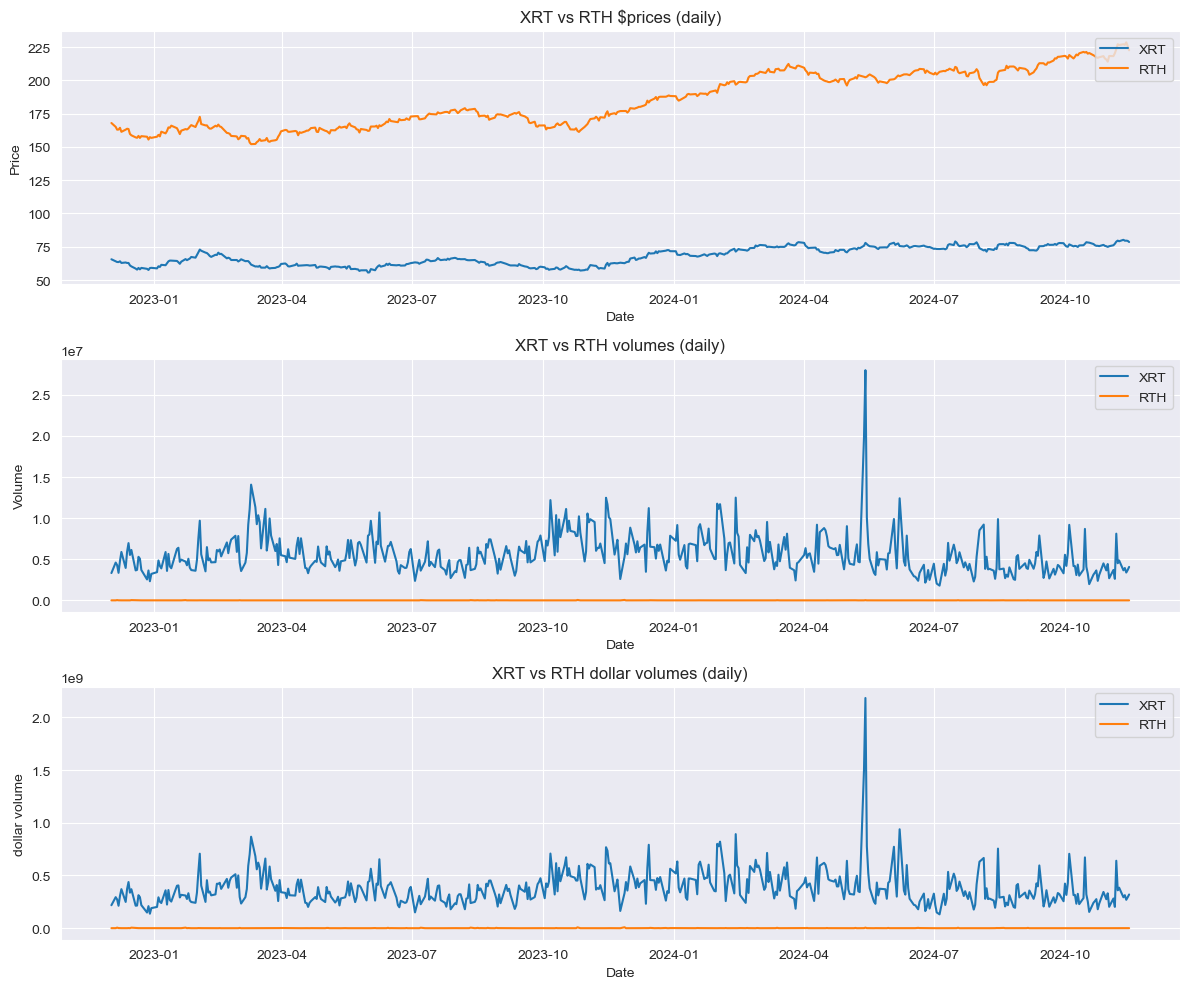

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(df[df['ticker'] == 'XRT']['adj_close'], label='XRT')
axes[0].plot(df[df['ticker'] == 'RTH']['adj_close'], label='RTH')
axes[0].set_title("XRT vs RTH $prices (daily)")
axes[0].set_ylabel("Price")
axes[0].set_xlabel("Date")
axes[0].legend(loc="upper right")

axes[1].plot(df[df['ticker'] == 'XRT']['volume'], label='XRT')
axes[1].plot(df[df['ticker'] == 'RTH']['volume'], label='RTH')
axes[1].set_title("XRT vs RTH volumes (daily)")
axes[1].set_ylabel("Volume")
axes[1].set_xlabel("Date")
axes[1].legend(loc="upper right")

axes[2].plot(df[df['ticker'] == 'XRT']['daily_dollar_volume'], label='XRT')
axes[2].plot(df[df['ticker'] == 'RTH']['daily_dollar_volume'], label='RTH')
axes[2].set_title("XRT vs RTH dollar volumes (daily)")
axes[2].set_ylabel("dollar volume")
axes[2].set_xlabel("Date")
axes[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


XRT has higher dollar volume and greater liquidity compared to RTH because:
- Equal Weighting: XRT’s equal-weighted structure appeals to a broader range of traders seeking diversified exposure to the retail sector, leading to higher trading activity.
- Number of Holdings: XRT holds more stocks (~80-100 vs. RTH's 25), attracting investors looking for broader retail market exposure.
- Popularity with Traders: XRT is widely used by short-term traders and options traders due to its active trading and volatility, boosting its liquidity.

Therefor N_t = trailing 15 day median of less liquid ETF -> RTH

In [21]:
final_cols = ['daily_dollar_volume', 'adj_close', 'adj_volume']
xrt_df = df[df['ticker']=='XRT'][final_cols]
rth_df = df[df['ticker']=='RTH'][final_cols]

In [22]:
def trailing_median(df, input_col, output_col, win):
    df[output_col] = df[input_col].rolling(win, min_periods=1).median()
    df = df.drop(input_col, axis=1)
    return df

In [23]:
win = 15
input_col = 'daily_dollar_volume'
output_col = 'trailing_15_day_median'
xrt_df = trailing_median(xrt_df, input_col, output_col, win)
rth_df = trailing_median(rth_df, input_col, output_col, win)

In [24]:
xrt_df.columns = [col + '_xrt' for col in xrt_df.columns]
rth_df.columns = [col + '_rth' for col in rth_df.columns]

In [25]:
final_df = pd.merge(xrt_df, rth_df, on='date', how='inner')

In [26]:
final_df.head()

,adj_close_xrt,adj_volume_xrt,trailing_15_day_median_xrt,adj_close_rth,adj_volume_rth,trailing_15_day_median_rth
date,,,,,,
2022-12-02,65.634520,3323707.0,2.181499e+08,167.936443,4106.0,6.895470e+05
2022-12-05,64.048009,4598097.0,2.563244e+08,165.043872,3930.0,6.690847e+05
2022-12-06,63.587725,4295169.0,2.731200e+08,162.960775,34131.0,6.895470e+05
2022-12-07,63.528966,3351745.0,2.456350e+08,162.999894,9374.0,1.108754e+06
2022-12-08,64.116562,4774620.0,2.731200e+08,164.349506,5063.0,8.321016e+05


In [27]:
final_df['N_t'] = final_df[['trailing_15_day_median_xrt', 'trailing_15_day_median_rth']].min(axis=1)

In [28]:
final_df.head()

,adj_close_xrt,adj_volume_xrt,trailing_15_day_median_xrt,adj_close_rth,adj_volume_rth,trailing_15_day_median_rth,N_t
date,,,,,,,
2022-12-02,65.634520,3323707.0,2.181499e+08,167.936443,4106.0,6.895470e+05,6.895470e+05
2022-12-05,64.048009,4598097.0,2.563244e+08,165.043872,3930.0,6.690847e+05,6.690847e+05
2022-12-06,63.587725,4295169.0,2.731200e+08,162.960775,34131.0,6.895470e+05,6.895470e+05
2022-12-07,63.528966,3351745.0,2.456350e+08,162.999894,9374.0,1.108754e+06,1.108754e+06
2022-12-08,64.116562,4774620.0,2.731200e+08,164.349506,5063.0,8.321016e+05,8.321016e+05


### Trading Strategy: Spread-reversion
Spread reversion analysis

In [29]:
final_df['return_xrt'] = final_df['adj_close_xrt'].pct_change()
final_df['return_rth'] = final_df['adj_close_rth'].pct_change()

In [30]:
correlation = final_df['return_xrt'].corr(final_df['return_rth'])
print(f"Correlation between XRT Return and RTH Return: {correlation*100:.2f}%")

Correlation between XRT Return and RTH Return: 72.36%


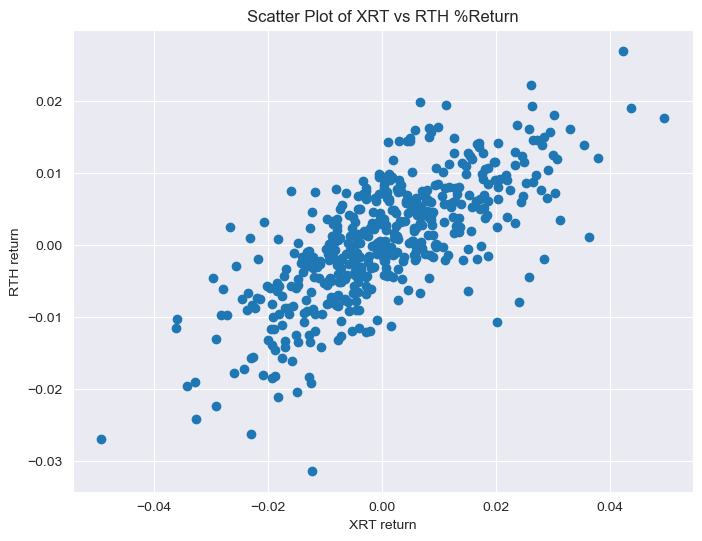

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['return_xrt'], final_df['return_rth'])
plt.title(f"Scatter Plot of XRT vs RTH %Return")
plt.xlabel("XRT return")
plt.ylabel("RTH return")
plt.show()

In [32]:
final_df['spread'] = final_df['return_xrt']-final_df['return_rth']

In [33]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(final_df['spread'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("Reject the null hypothesis: The series is likely mean-reverting.")
else:
    print("Fail to reject the null hypothesis: The series is likely not mean-reverting.")

ADF Statistic: -12.188202741856562
p-value: 1.3039256131831585e-22
Reject the null hypothesis: The series is likely mean-reverting.


XRT Return and RTH Returns are 72% correlated. Since both ETFs track retail sector in the US, containing overlapping companies such as Walmart, Amazon etc, they are highly correlated despite their structural differences. ADF test for daily spread (difference in returns of XRT and RTH) suggests that the spread is stationary and hence mean-reverting.

In [34]:
final_df['z'] = final_df['return_xrt'].rolling(15).mean() - final_df['return_rth'].rolling(15).mean()

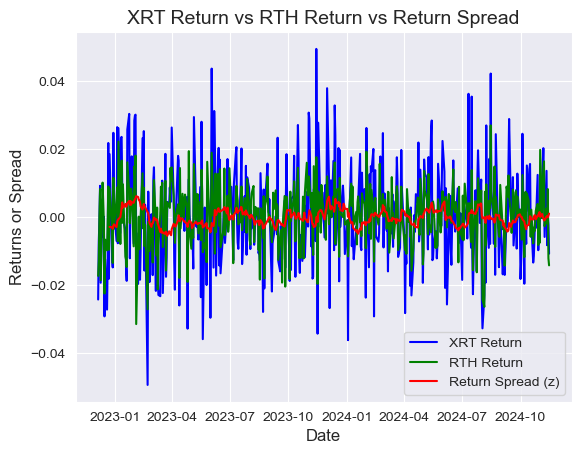

In [35]:
plt.plot(final_df['return_xrt'], label='XRT Return', color='blue')
plt.plot(final_df['return_rth'], label='RTH Return', color='green')
plt.plot(final_df['z'], label='Return Spread (z)', color='red')

plt.title("XRT Return vs RTH Return vs Return Spread", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns or Spread", fontsize=12)
plt.legend(loc='best')
plt.show()

### Trading strategy code

In [36]:
def trading_strategy(final_df, M, j, g, s, zeta, start_row, stop_loss_month):

    final_df['z'] = final_df['return_xrt'].rolling(M).mean() - final_df['return_rth'].rolling(M).mean()

    pnl_dict = {}  # Initialize cumulative PnL
    current_position = None  # Track the open position
    all_positions = []  # Track all positions (entry and exit)
    final_pnl = 0

    for i in range(start_row, len(final_df)):
        current_date = final_df.index[i]
        curr_month = f"{current_date.year}_{current_date.month}"
        N_t = final_df['N_t'].iloc[i]
        z = final_df['z'].iloc[i]

        # Skip trading if current month matches stop loss month
        if curr_month == stop_loss_month:
            continue

        # Check for open positions
        if current_position:
            entry_cash = current_position['entry_cash']
            pnl = (final_df['adj_close_xrt'].iloc[i] - current_position['entry_X']) * current_position['shares_X'] + \
                  (current_position['entry_Y'] - final_df['adj_close_rth'].iloc[i]) * current_position['shares_Y']
            # Subtract trading costs
            pnl -= zeta * entry_cash

            # Stop loss check
            if pnl < -s * entry_cash:
                final_pnl+=pnl
                pnl_dict[str(current_date.date())] = [pnl, final_pnl]
                stop_loss_month = curr_month  # Set stop loss month
                current_position['exit_date'] = current_date
                current_position['exit_pnl'] = pnl
                current_position['type'] = 'Stop Loss Position Closed'
                all_positions.append(current_position.copy())
                current_position = None  # Close the position
                continue

            # Exit condition
            elif abs(z) < j:
                final_pnl+=pnl
                pnl_dict[str(current_date.date())] = [pnl, final_pnl]
                current_position['exit_date'] = current_date
                current_position['exit_pnl'] = pnl
                current_position['type'] = 'Position Closed'
                all_positions.append(current_position.copy())
                current_position = None  # Close the position
                continue

        # Entry condition
        if abs(z) > g and not current_position:
            shares_X = int((N_t / 100) / final_df['adj_close_xrt'].iloc[i])
            shares_Y = int((N_t / 100) / final_df['adj_close_rth'].iloc[i])
            entry_cash = 2 * N_t / 100

            if z > 0:
                # Short X, Long Y
                current_position = {'entry_X': final_df['adj_close_xrt'].iloc[i],
                                'entry_Y': final_df['adj_close_rth'].iloc[i],
                                'shares_X': -shares_X,
                                'shares_Y': shares_Y,
                                'entry_cash': entry_cash,
                                'entry_date': current_date,
                                'type': 'Short XRT, Long RTH'}
            else:
                # Long X, Short Y
                current_position = {'entry_X': final_df['adj_close_xrt'].iloc[i],
                                'entry_Y': final_df['adj_close_rth'].iloc[i],
                                'shares_X': shares_X,
                                'shares_Y': -shares_Y,
                                'entry_cash': entry_cash,
                                'entry_date': current_date,
                                'type': 'Long XRT, Short RTH'}
            all_positions.append(current_position.copy())

    # Force close at the end of the period
    if current_position:
        pnl = (final_df['adj_close_xrt'].iloc[-1] - current_position['entry_X']) * current_position['shares_X'] + \
              (current_position['entry_Y'] - final_df['adj_close_rth'].iloc[-1]) * current_position['shares_Y']
        pnl -= zeta * current_position['entry_cash']
        final_pnl+=pnl
        pnl_dict[str(final_df.index[len(final_df)-1].date())] = [pnl, final_pnl]
        current_position['exit_date'] = final_df.index[-1]
        current_position['exit_pnl'] = pnl
        current_position['type'] = 'Position Closed'
        all_positions.append(current_position.copy())
    return final_pnl, pnl_dict, all_positions

In [37]:
def plot_trading_strategy(final_df, all_positions, j, g):
    points = {
        'Long XRT, Short RTH': {'dates': [], 'z': [], 'color': 'green', 'label': 'Long XRT, Short RTH'},
        'Short XRT, Long RTH': {'dates': [], 'z': [], 'color': 'red', 'label': 'Short XRT, Long RTH'},
        'Position Closed': {'dates': [], 'z': [], 'color': 'orange', 'label': 'Position Closed'},
        'Stop Loss Position Closed': {'dates': [], 'z': [], 'color': 'purple', 'label': 'Stop Loss Closed'}
    }

    for pos in all_positions:
        pos_type = pos.get('type')
        if pos_type in points:
            date_key = 'entry_date' if pos_type in ['Long XRT, Short RTH', 'Short XRT, Long RTH'] else 'exit_date'
            points[pos_type]['dates'].append(pos[date_key])
            points[pos_type]['z'].append(final_df.loc[pos[date_key], 'z'])

    plt.figure(figsize=(12, 6))
    plt.plot(final_df.index, final_df['z'], color='blue', linewidth=1)

    plt.fill_between(final_df.index, j, g, color='pink', alpha=0.2)
    plt.fill_between(final_df.index, -j, -g, color='pink', alpha=0.2)

    for point_type, data in points.items():
        plt.scatter(data['dates'], data['z'], color=data['color'], label=data['label'], zorder=5)

    plt.axhline(y=j, color='orange', linestyle='--')
    plt.axhline(y=-j, color='orange', linestyle='--')
    plt.axhline(y=g, color='green', linestyle='--')
    plt.axhline(y=-g, color='green', linestyle='--')

    plt.title(f'z(t) M-day return difference (XRT and RTH) with Entry and Exit points\nNumber of trades = {len(all_positions)}', fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("z(t)", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [38]:
def plot_cumulative_pnl(pnl_dict, final_pnl, capital):
    sorted_dates = sorted(pnl_dict.keys())
    sorted_pnl = [pnl_dict[date][1] for date in sorted_dates]
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_dates, sorted_pnl, marker='o', linestyle='-', color='blue', label='Cumulative PnL')
    plt.title(
        f"Profit = $ {final_pnl:.2f}\nReturn on Capital: {((final_pnl / capital) * 100):.3f}%",
        fontsize=14
    )

    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative PnL', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Running the trading strategy
I have initialised j, g with values close to 25th and 75th percentile of z(t)

In [39]:
#parameters
M = 15 # Moving average window
g = 0.0016 # Entry threshold
j = 0.001 # Exit threshold
s = 0.05 # Stop loss parameter
zeta = 0.00001 # Trading cost parameter

start_row = final_df.index.get_loc('2023-01-03')
stop_loss_month = '2022_11' # initialising with a value before our trading strategy start date

In [40]:
# Example usage of the function
final_pnl, pnl_dict, all_positions = trading_strategy(
    final_df=final_df,
    M=M,
    j=j,
    g=g,
    s=s,
    zeta=zeta,
    start_row=start_row,
    stop_loss_month=stop_loss_month
)

In [41]:
print(len(all_positions)) # has both entry position and closing position
print(len(pnl_dict))

66
33


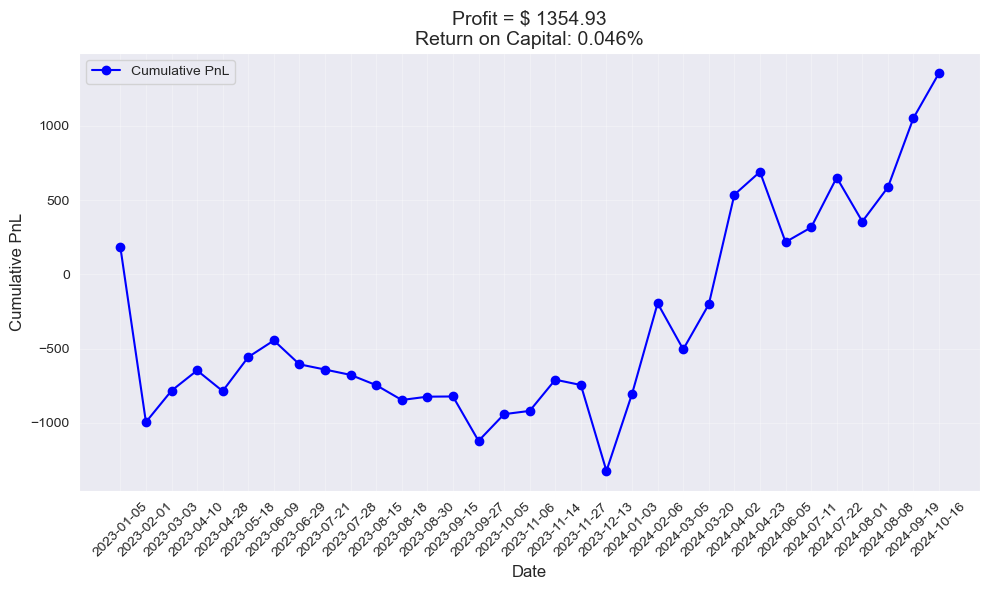

In [42]:
plot_cumulative_pnl(pnl_dict, final_pnl, final_df['N_t'].max() * 2)

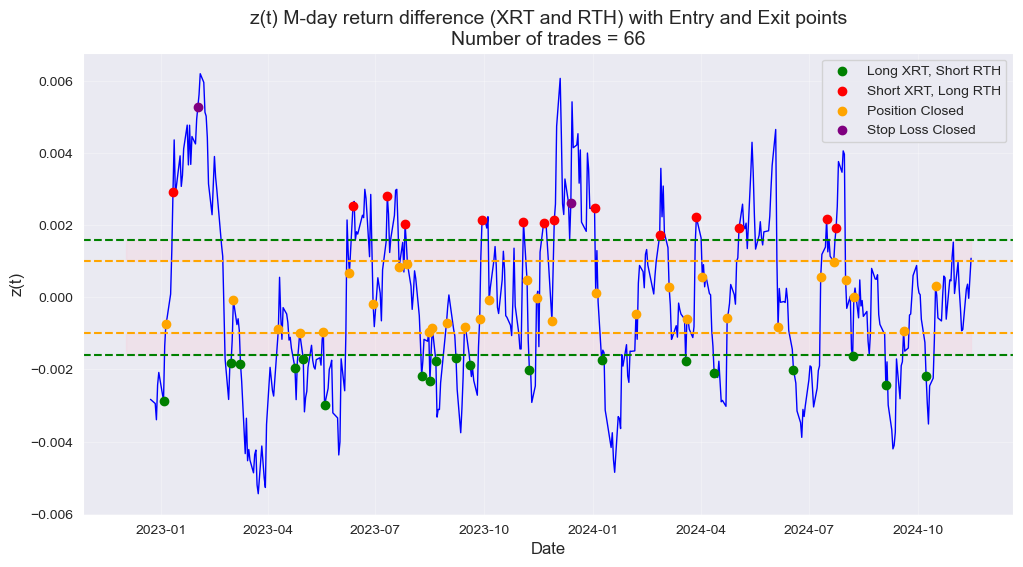

In [43]:
plot_trading_strategy(final_df, all_positions, j, g)

**Graph Explanation:**
- Bands are between (+j, +g) and (-j, -g), outside of which trading happens
- when spread>+g, means XRT returns > RTH returns => spread is increasing as XRT return is increasing more than RTH, so we short XRT and Long RTH (given by Red dots) above (+j, +g) band
- when spread<-j, means RTH returns > XRT returns => spread is increasing as RTH return is increasing more than XRT, so we Short RTH and Long XRT (given by Green dots) below (-j, -g) band
- when magnitude of spread is < j, we close/flat our positions if any (given by yellow dots)
- Stop loss threshold, when pnl < -proportion of entry cash, we close/flat our positions (given by pink dots)



### Tuning Parameters M, j, g, s

- M = [2,5,10,15,20]
- j = [0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
- g = [0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045]
- s = [0.02, 0.05, 0.1, 0.15, 0.2]

In [44]:
zeta = 0.00001
start_row = final_df.index.get_loc('2023-01-03')
stop_loss_month = '2022_11'

result_list=[]
for M in [2,5,10,15,20]:
    for j in np.arange(0.0005, 0.003, 0.0005):
        for g in np.arange(0.0005, 0.005, 0.0005):
            for s in [0.02, 0.05, 0.1, 0.15, 0.2]:
                if j<g:
                    final_pnl, _, _ = trading_strategy(final_df, M, j, g, s, zeta, start_row, stop_loss_month)
                    std_dev = np.std(final_df['z'])
                    result_list.append([M,j,g,s,final_pnl,std_dev, final_pnl/std_dev])

results=pd.DataFrame(result_list,columns=["M","j","g","s","Pnl", 'std dev', 'return/risk'])

In [45]:
results.sort_values(by = ['Pnl'], ascending=False)

,M,j,g,s,Pnl,std dev,return/risk
1,2,0.0005,0.0010,0.05,7067.307844,0.007088,997075.838768
2,2,0.0005,0.0010,0.10,7067.307844,0.007088,997075.838768
3,2,0.0005,0.0010,0.15,7067.307844,0.007088,997075.838768
4,2,0.0005,0.0010,0.20,7067.307844,0.007088,997075.838768
21,2,0.0005,0.0030,0.05,6916.519545,0.007088,975802.197805
...,...,...,...,...,...,...,...
313,10,0.0005,0.0020,0.15,-1781.644781,0.002835,-628418.572451
456,15,0.0005,0.0015,0.05,-2049.990026,0.002289,-895597.532361
153,5,0.0005,0.0010,0.15,-2497.510624,0.004229,-590604.985163
154,5,0.0005,0.0010,0.20,-2497.510624,0.004229,-590604.985163


Observations:
- Profit Maximization: The highest profit is $7,067.
- Preference for Lower M Values: The analysis reveals a preference for lower values of M(rolling period). This suggests that shorter-term moving averages are more effective in capturing profitable trading opportunities, likely due to their ability to respond more quickly to market fluctuations.
- Stop-Loss Optimization: A stop-loss threshold set at 10% of the entry cash is a conservative measure. It balances risk management by limiting losses while allowing the strategy sufficient room to generate profits.

### Runner-up Strategy:
- M=2
- j=0.0005
- g=0.003
- s=0.1

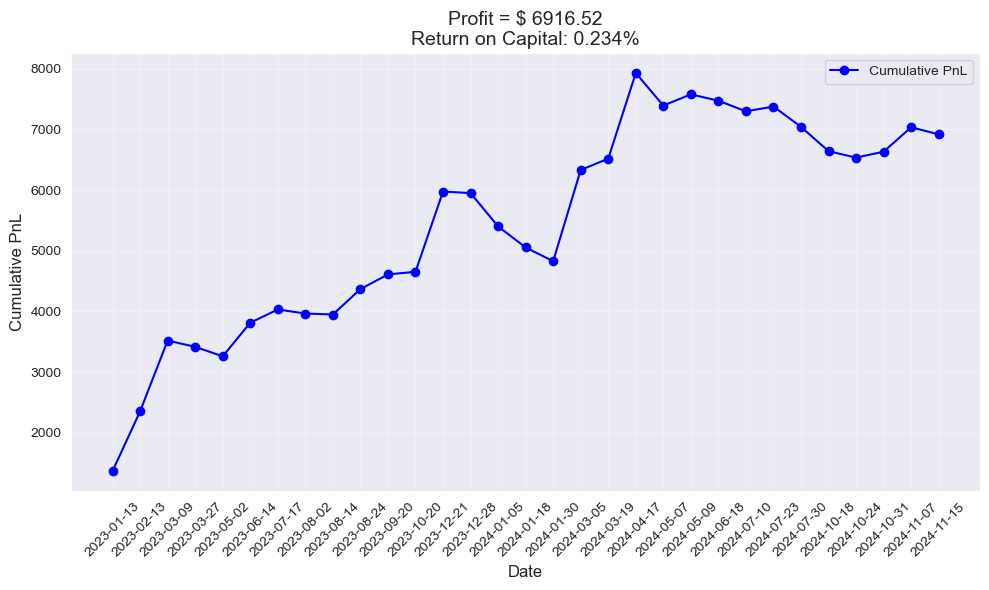

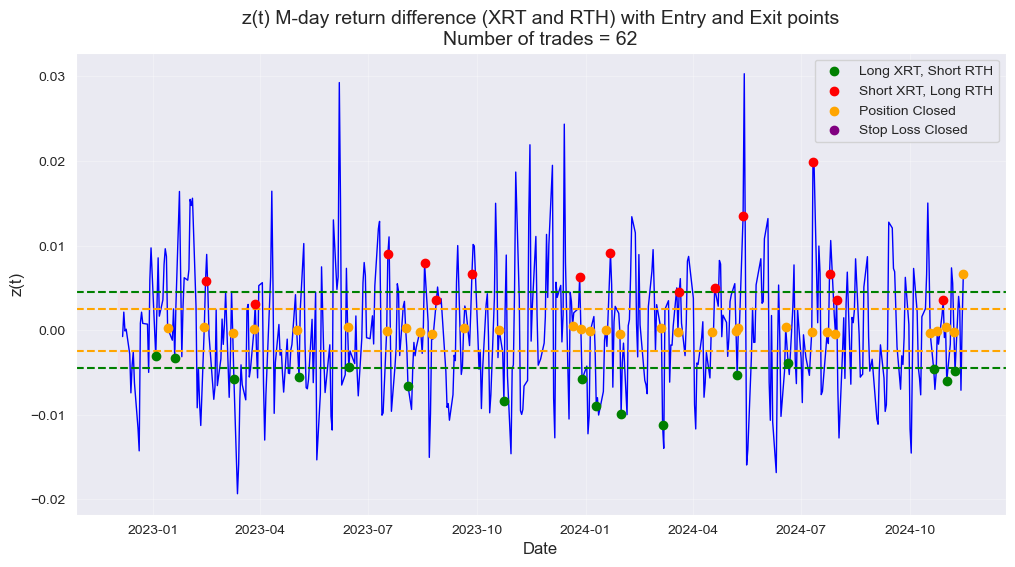

In [46]:
# Example usage of the function
final_pnl, pnl_dict, all_positions = trading_strategy(
    final_df=final_df,
    M=2,
    j=0.0005,
    g=0.003,
    s=0.1,
    zeta=0.00001,
    start_row=start_row,
    stop_loss_month=stop_loss_month
)
plot_cumulative_pnl(pnl_dict, final_pnl, final_df['N_t'].max() * 2)
plot_trading_strategy(final_df, all_positions, j, g)

No stop-loss triggered and cumulative PnL is closely monotonic, implying a stable strategy

### Top Strategy:
- M=2
- j=0.0005
- g=0.001
- s=0.1

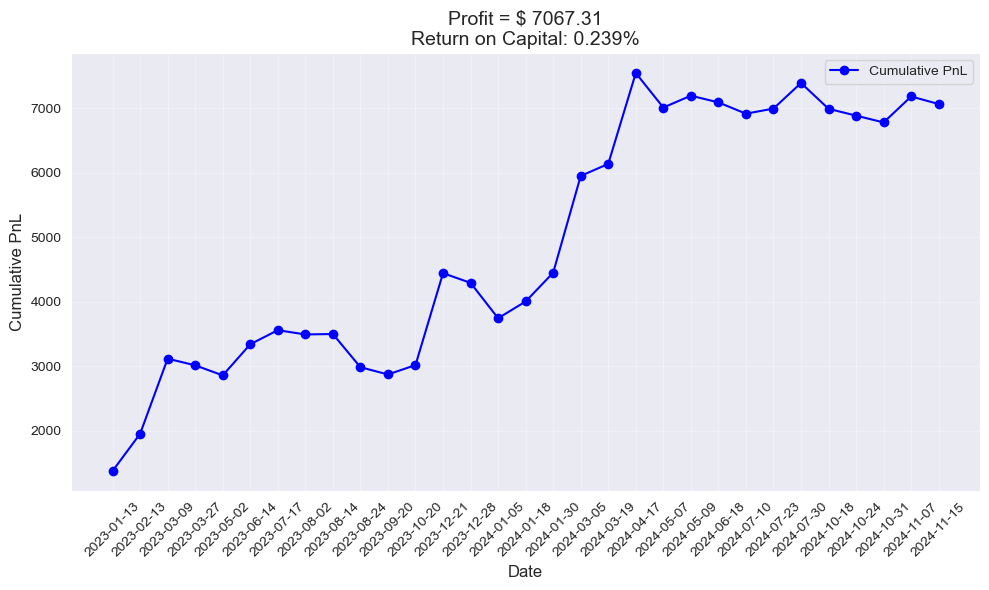

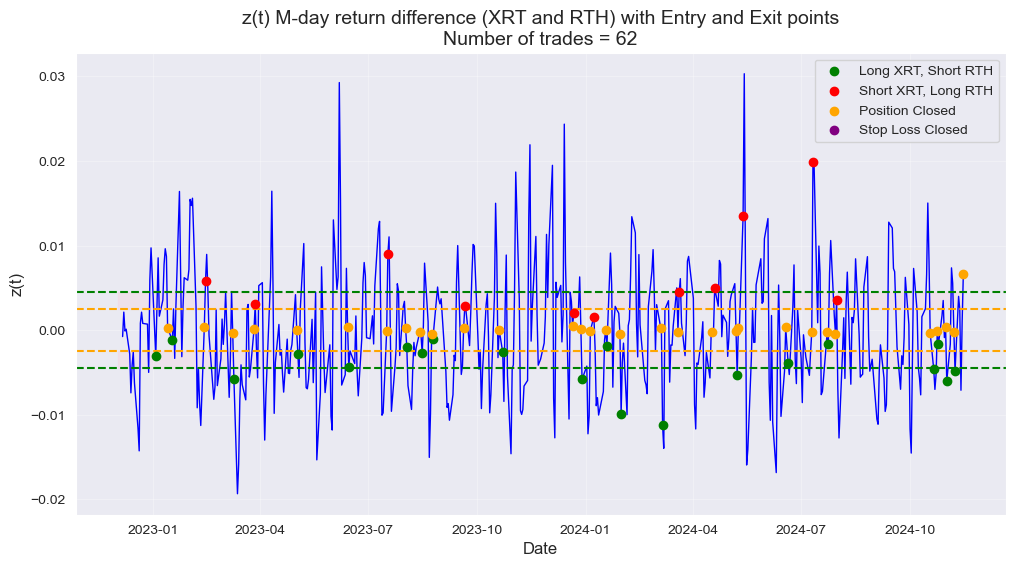

In [47]:
# Example usage of the function
final_pnl, pnl_dict, all_positions = trading_strategy(
    final_df=final_df,
    M=2,
    j=0.0005,
    g=0.001,
    s=0.1,
    zeta=0.00001,
    start_row=start_row,
    stop_loss_month=stop_loss_month
)
plot_cumulative_pnl(pnl_dict, final_pnl, final_df['N_t'].max() * 2)
plot_trading_strategy(final_df, all_positions, j, g)

No stop-loss triggered and cumulative PnL is closely monotonic, implying a stable strategy and marginally better than previous.

### Final Profit without trading costs

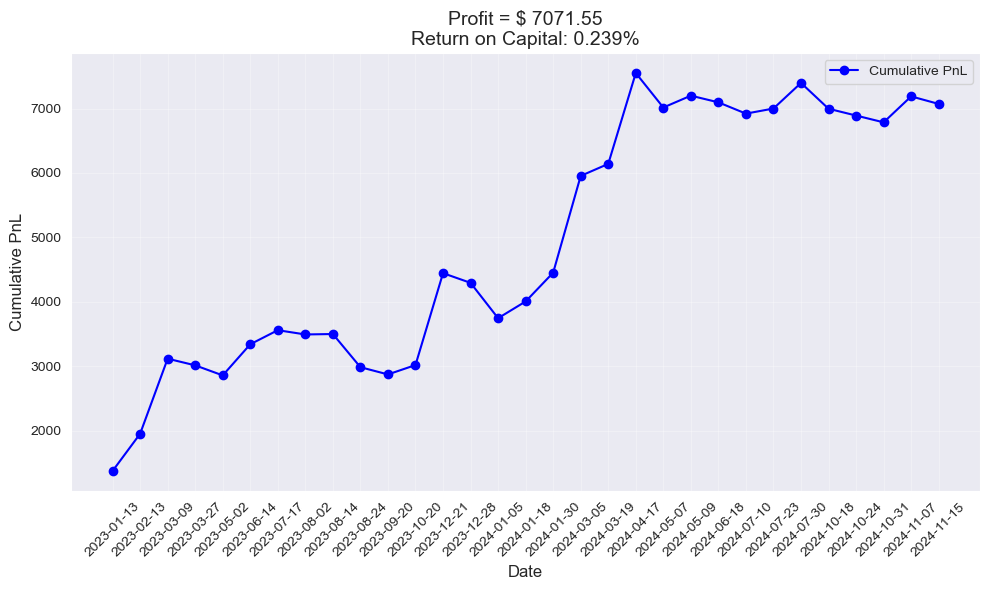

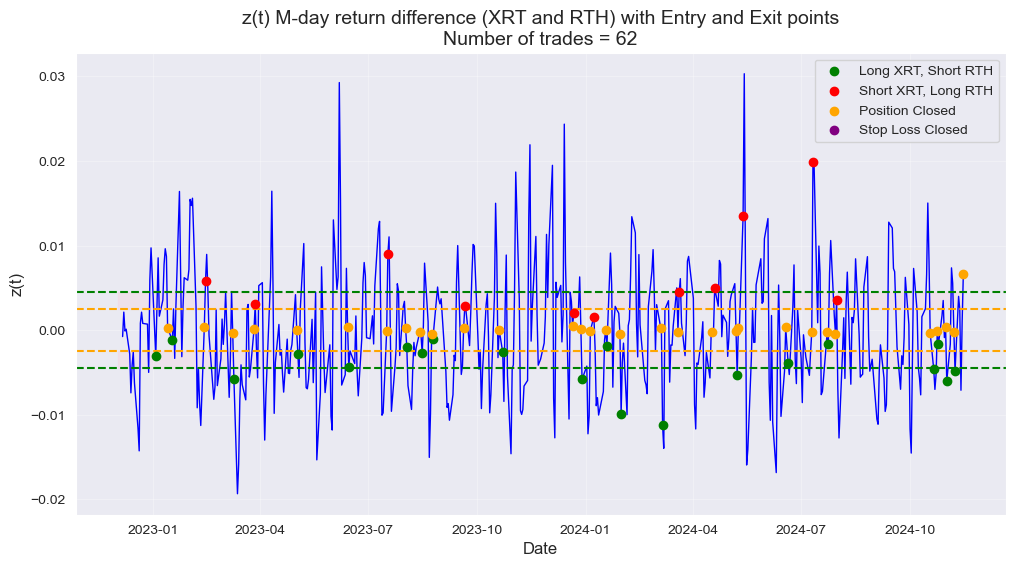

In [48]:
# Example usage of the function
final_pnl, pnl_dict, all_positions = trading_strategy(
    final_df=final_df,
    M=2,
    j=0.0005,
    g=0.001,
    s=0.1,
    zeta=0,
    start_row=start_row,
    stop_loss_month=stop_loss_month
)

plot_cumulative_pnl(pnl_dict, final_pnl, final_df['N_t'].max() * 2)

plot_trading_strategy(final_df, all_positions, j, g)

### Correlations to Fama French factor returns

In [49]:
strategy_pnl = pd.DataFrame.from_dict(pnl_dict, orient='index', columns=['Daily_PnL', 'Cumulative_PnL'])
strategy_pnl.index = pd.to_datetime(strategy_pnl.index)

In [50]:
merged_data = strategy_pnl.merge(ff5, left_index=True, right_index=True)

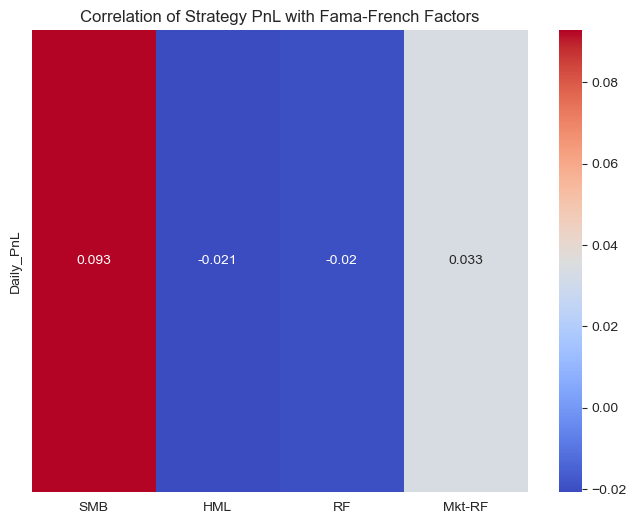

In [51]:
correlations = merged_data[['Daily_PnL', 'SMB', 'HML', 'RF', 'Mkt-RF']].corr()
correlations_subset = correlations.loc[['Daily_PnL'], ['SMB', 'HML', 'RF', 'Mkt-RF']]

plt.figure(figsize=(8, 6))
sns.heatmap(correlations_subset, annot=True, cmap='coolwarm', cbar=True)
plt.title("Correlation of Strategy PnL with Fama-French Factors")
plt.show()


<Axes: >

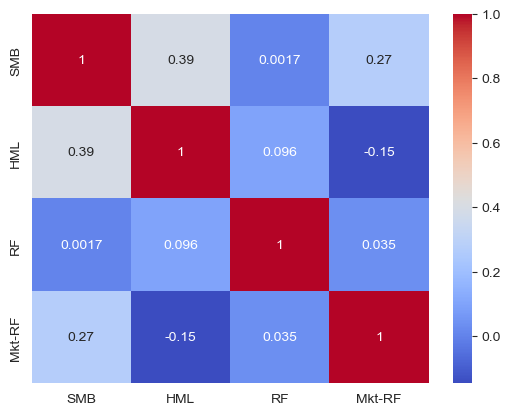

In [52]:
sns.heatmap(ff5.corr(), annot=True, cmap='coolwarm', cbar=True)

We can see that 'SMB', 'HML', 'RF', 'Mkt-RF' dont have very high correlations with each other as expected.

Correlation between the factors and Daily PnL from the top strategy is very low, indicating spread-trading strategy performance is uncorrelated to broad market factors.

The slight positive correlation with the SMB factor suggests that the strategy's profitability may be mildly influenced by the performance of small-cap stocks relative to large-cap stocks. This relationship can be explained by the composition of the XRT ETF, which provides broad retail sector exposure across small-, mid-, and large-cap companies. In contrast, RTH primarily holds large-cap retail giants, resulting in less sensitivity to the SMB factor.

In [53]:
import statsmodels.api as sm

merged_data = ff5.merge(final_df[['z']].dropna(), left_index=True, right_index=True)

X = merged_data[['SMB', 'HML', 'RF', 'Mkt-RF']]
y = merged_data['z']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     42.01
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           2.96e-30
Time:                        21:47:47   Log-Likelihood:                 1802.8
No. Observations:                 490   AIC:                            -3596.
Df Residuals:                     485   BIC:                            -3575.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.848      0.3

Spread is not completely explained by Fama-French factors, indicating other drivers influencing it

###  SVOL Analysis

Correlation between Strategy PnL and SVOL Levels: 0.09


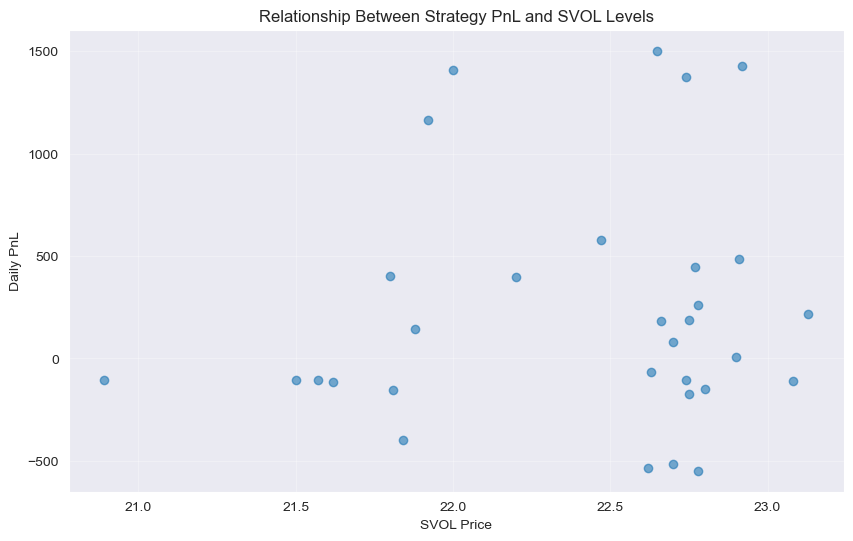

In [54]:
svol_df = df[df['ticker']=='SVOL']

merged_svol_data = strategy_pnl.merge(svol_df, left_index=True, right_index=True)

svol_correlation = merged_svol_data['Daily_PnL'].corr(merged_svol_data['adj_close'])
print(f"Correlation between Strategy PnL and SVOL Levels: {svol_correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(merged_svol_data['adj_close'], merged_svol_data['Daily_PnL'], alpha=0.6)
plt.title("Relationship Between Strategy PnL and SVOL Levels")
plt.xlabel("SVOL Price")
plt.ylabel("Daily PnL")
plt.grid(alpha=0.3)
plt.show()


Correlation between Strategy spread and SVOL Levels: 0.14


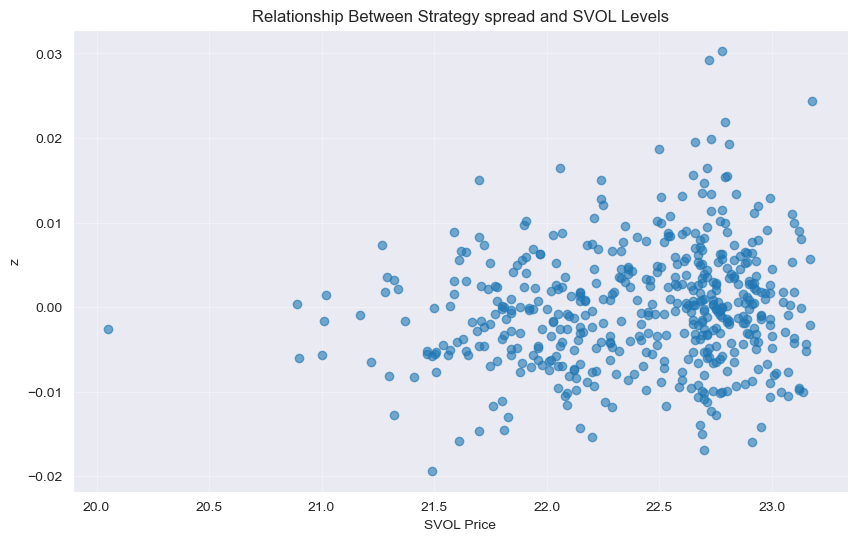

In [55]:
merged_svol_data_2 = final_df.merge(svol_df, left_index=True, right_index=True)

svol_correlation = merged_svol_data_2['z'].corr(merged_svol_data_2['adj_close'])
print(f"Correlation between Strategy spread and SVOL Levels: {svol_correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(merged_svol_data_2['adj_close'], merged_svol_data_2['z'], alpha=0.6)
plt.title("Relationship Between Strategy spread and SVOL Levels")
plt.xlabel("SVOL Price")
plt.ylabel("z")
plt.grid(alpha=0.3)
plt.show()


The low correlation between SVOL prices and PnL (9%) and between SVOL prices and spread (14%), combined with the lack of a discernible relationship in the scatter plot, suggests that expected market volatility (as represented by SVOL) has minimal direct impact on the PnL and spreads.

This indicates that factors other than market volatility—such as trade execution, strategy dynamics, or other market conditions—are likely driving the PnL and spread. Essentially, while SVOL serves as a proxy for expected volatility, its influence on these specific metrics appears to be limited or negligible.